# Mean Reversion: Intuition and Background.

## What is Mean Reversion ?

Instead of starting with a deep scientific (either mathematical or psychological) definition of Mean Reversion, I prefer to appeal to the 'guts' of a trader who is looking for them. For a trader, a mean-reverting signal is the time series of prices of an asset or a portfolio of assets that kind of moves upwards and downwards around a constant mean. When this mythical signal is discovered, the trader will simply 'buy low, sell high'.

Using the magic of jupyter books, I can show some real examples on code that anyone can run. Let me show you a typical signal used in Fixed Income: the Treasury Rates 2-5-10 butterfly (but keep in mind that you can change the parameters below to do your own exploring).

First, I show how to download and plot the whole term structure:

['Date', '1 MO', '3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']


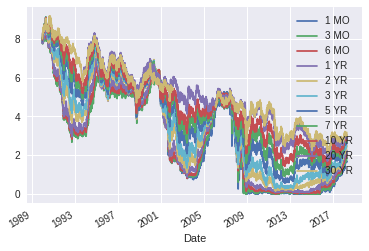

In [1]:
# -*- coding: utf-8 -*-

# In this section I add the initial libraries required for this tutorial
# 'requests': allow HTTP-post API calls
import requests
# 'json':     to format as json calls to API
import json 
# 'pandas':   to plot the timeseries
import pandas as pd
# 'datetime': to convert different date formats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

# defining the api-endpoint 
API_ENDPOINT = "https://markovsimulator.azurewebsites.net/api/MarkovCalibrator_01?code=UFYL9CcFRERnVbZJ3ELdRRY7u59vD3BgONzaGLNEOekTfKf0Ug9Bfw=="

# Treasury rates: we can download them from Quandl
QUAND_TS = "https://www.quandl.com/api/v3/datasets/USTREASURY/YIELD.json?api_key=o6YKGjyDcseE3LFKrSK3"


# Call Quandl to get all the data
q = requests.get(url = QUAND_TS)
q_json = q.json() 
q_data = q_json['dataset']['data']

# Compute derived series from Quandl Data
dates = []
values = []
q_len = len(q_data)
column_len = len(q_data[0])
column = column_len-1
columns = q_json['dataset']['column_names']
print (columns)


# The following could be easily done using Quandl's
# python API - but I keep it the 'hard way' to allow
# compatibility with Google Colaboratory
df_rates = pd.DataFrame.from_records(q_data, columns = columns)
df_rates['Date'] = pd.to_datetime(df_rates['Date'])
df_rates.set_index('Date', inplace=True)
df_rates.plot()


Below, I will pick only the rate history corresponding to the 2-5-10 butterfly, and then compute its time series using the 1-2-1 weights (also known as 50:50 as the weights of the 2s and 10s 'wings' are half of the 5s 'body').

The plot will result (hopefully) in a time series that moves around zero and goes from -0.6 to +0.8: this is usually one of 'typical' mean reverting signals found by practiotioners.

       0
2 YR  -1
5 YR   2
10 YR -1


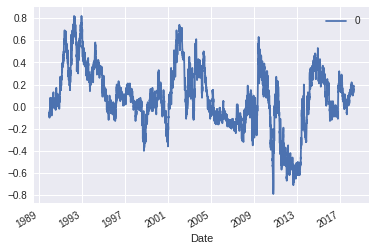

In [2]:



# columns names: ["Date","1 MO","3 MO","6 MO","1 YR","2 YR","3 YR","5 YR","7 YR","10 YR","20 YR","30 YR"]
# as the index start from 0, columns 2,5 and 10 are:
cols = [5, 7, 9]

columns_fly = [columns[i] for i in cols]
TimeSeries = df_rates[columns_fly]

# I use this line to keep each weight linked to the name of the maturity
Weights = pd.DataFrame([-1, 2, -1], index = TimeSeries.columns)
print (Weights)

# Now all I have to is the 'dot' product of Weights and TimeSeries
butterfly_ts = (TimeSeries.dot(Weights)).dropna()
butterfly_ts.plot()


Now that we can *see* what a mean reverting timeseries looks like, a practicioner can visually identify what the mean looks like (zero) and the bands where the signal spend most of the time (-0.6 and +0.6). 
Here is where quants started providing value - by properly modeling the Time Series we could add more useful information: 
 
*   how long could it take it to revert to the mean ? 
*   how probable is that it will be around (or far away from) the mean in the next days ?
*   is this signal _really_ mean reverting ? (a seasoned practicioner will notice the different behaviours in 1990 to 1996, 1996 to 2001, 2001 to 2006, etc., but for the sake of illustration just keep an open mind for the moment.)

**Note:** If you are reading this from the github source, some of the formulas below will be scrambled. Try the Google Colaboratory [original version](https://colab.research.google.com/drive/1dEjjPPpJ6FVzgZaqp1EjYENSwE7Q9TU8#scrollTo=9I20sctA9dPa).

To answer this questions quants introduced mathematical modeling using stochastic processes, and defined Mean Reversion as:

>The simple Ornstein-Uhlenbeck mean reverting (OUMR) process given by the stochastic differential
equation (SDE)
$$d x(t) = \theta(\mu - x(t)) dt + \sigma dB(t),$$ 
$$x(0) = x_0$$
for constants $\mu$, $\theta$, $\sigma$ and $x_0$ and where $B(t)$ is standard Brownian motion.
In this model the process $x(t)$ fluctuates randomly, but tends to revert to some fundamental
level $\mu$. The behavior of this 'reversion' depends on both the short term standard deviation $\sigma$ and
the speed of reversion parameter $\theta$

Using the definition above, and with *known* values of $\theta$ and $\sigma$ we are now able to answer the questions we posed above. For readers that are mathematically inclined, we refer them to the [Wikipedia entry](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) where it is shown the full derivation of the stochastic process.

While the math seems nice, we start to lose the intuition. On the example above we visually noticed the (-0.6, 0.6) band, a mean of 0, and oscillations that take a couple of years for it to return to the mean - where is that information in the formulas ? 

The mean seems simple enough - it looks (and it is) the 'fundamental level' $\mu$. 

Practitioners used to the [68-95-99.7](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) rule (a 2 standard deviation band roughly comprises 95% of observations) and who 'eyeball' the (-0.6, 0.6) band as 2 std around the mean of 0 would think $\sigma$ is roughly 0.3. But $\sigma$ *does not* correspond to the width of the band, instead it has to scaled by the mean reversion speed $\theta$:
$$\operatorname {var} (x(t))={{\sigma ^{2}} \over {2\theta} }.\,$$
$$\operatorname {std band} = \sqrt { {{\sigma ^{2}} \over {2\theta} } }$$
Practitioners tend to use [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands) to "guesstimate" the standard deviation band and trade whenenever the signal reaches a certain multiple (usually 2) - see my [last notebook](https://colab.research.google.com/drive/11i2hkrrxC9msa4YqFr6NF9SZ7QpOELvj).

We need to know $\theta$ (the mean reversion speed) to get the correct $\operatorname {var} (x(t))$. This extra complexity brings the advantage of being able to compute the amount of time required for the series to go from any level to half way closer to the mean:
$$\operatorname {half life} = {{ \operatorname{ln}(2)} \over {\theta}}$$





### Expected Forward Path

The formulas for the forward path are:
$$E[x(t) | x_0]  = \bar{x} + (x_o - \bar{x}) e^{-\theta t}$$
and
$$\operatorname {Var}[ x(t) | x_0] = \frac{\sigma ^2}{2 \theta} \left(1 - e^{-2 \theta t} \right)$$ 

In python:


In [0]:
# Using the formulas to compute the forward expected mean and standard devition at some time
# t in the future (today being time '0', and expressed in terms of a year being one unit)
def OUmu_t(currentValue, mu, theta, t):
  return mu + (currentValue - mu)*np.exp(-theta * t)

def OUsigma_t(sigma, theta, t):
  return np.sqrt (  ( 1 - np.exp(-2 * theta * t)) * sigma * sigma / (2 * theta) )

# Calibrating Mean Reverting parameters

A practitioner will have some intuitive 'sense' (or 'gut feeling') of the mean reverting parameters, but if someone is analysing many signals it is better to automate the process. One method used to compute the parameters is 'Maximum Likelihood Expectation'; using Markov's API we can compute it and verify our intuition: 

In [4]:
# Time Series API format
json_ts =  {
   "calType" : "",
    "seriesName" : "butterfly",
    "colName" : "Value",
  "dates": [],  
  "vals" : []
}

# Preprocessing for API (from pandas TS)
butterfly_ts = butterfly_ts.dropna()
butterfly_ts.sort_index(inplace = True)
json_ts['vals'] = butterfly_ts[0].tolist()    
butterfly_ts['dates_'] = butterfly_ts.index
json_ts['dates'] = butterfly_ts['dates_'].apply(lambda x: x.strftime('%Y-%m-%d')).tolist()

# Calling the Azure function API:
r = requests.post(url = API_ENDPOINT, json = json_ts)
r_json = r.json()
print (r_json)

# Converting results to 'intuitive' numbers:
mean  = r_json['calibrationResult']['Mu']
print ('Mean:',mean)
sigma = r_json['calibrationResult']['Sigma']
# the API has a nomenclature difference;
# what I defined as theta in the text is called Lambda in the API
theta = r_json['calibrationResult']['Lambda']

# Using the formulas in the text to get the intuitive statistics
half_life = np.log(2)/ theta
print('Half life: (in years)', half_life)
std_band = np.sqrt( sigma * sigma / (2 * theta))
print('2 std band:', std_band*2)



{'calibrationResult': {'Mu': 0.082813422488164, 'Sigma': 0.5695768808832814, 'Lambda': 2.0780953997482516, 'LogLikelihood': -13991.690229656953, 'ProcessType': 'Mean Reverting', 'LastPrice': 0.18000000000000016, 'DaysPerYear': 365.25}, 'timeSeries': {}, 'ts_string': None, 'time_ser_dates': None, 'time_ser_values': None}
Mean: 0.082813422488164
Half life: (in years) 0.333549258924261
2 std band: 0.5587719675618271


The results are close to our initial 'eyeballing': mean is close to zero (at 8bps), half life of 0.33 years (3.6 months) visually fits with the 2 year cycles we identified to go from one side of the band to the other (one year to fully mean revert - roughly 6 times the half life), and finally the 2 standard deviation band of 0.55 is close to the visual range of (-0.6, 0.6) we identified.

the maximum fly level is: 0.8200000000000003


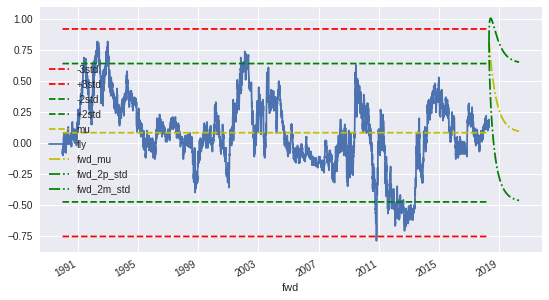

In [5]:
fly_augmented = butterfly_ts[0].to_frame('fly').dropna()
fly_augmented['mu'] = mean
fly_augmented['+2std'] = mean + std_band*2
fly_augmented['-2std'] = mean - std_band*2
fly_augmented['+3std'] = mean + std_band*3
fly_augmented['-3std'] = mean - std_band*3

last_row =  (fly_augmented.last('D'))
lt_date = last_row.index[0]
#lt_value = last_row['fly'][0]

# what happens if the last value is close to the
# 2 std band ?
lt_value = std_band*2+mean

# what happens at the maximum level
lt_value = fly_augmented['fly'].max()
print ('the maximum fly level is:', lt_value)

ax = fly_augmented.plot(style = ['-', 'y--', 'g--', 'g--', 'r--', 'r--'],
                       figsize = (9,5), legend ='reverse')

# Draw the forward path 6 x half life as mentioned above
rng = pd.date_range(last_row.index[0], 
                    periods=int(half_life*365.25*6), 
                    freq='D')
rng_days = (rng - last_row.index[0])
fwd = pd.Series(rng).to_frame('fwd')
fwd['fwd_mu'] = fwd['fwd'].apply(lambda x: OUmu_t(lt_value, mean, theta, (x - lt_date).days/365.25 ))
fwd['fwd_std'] = fwd['fwd'].apply(lambda x: OUsigma_t(sigma, theta, (x - lt_date).days/365.25 ))
fwd['fwd_2p_std'] = fwd['fwd_mu'] + 2 * fwd['fwd_std']
fwd['fwd_2m_std'] = fwd['fwd_mu'] - 2 * fwd['fwd_std']
fwd = fwd.set_index('fwd')
fwd[['fwd_mu', 'fwd_2p_std', 'fwd_2m_std']].plot(ax = ax, style = ['y-.', 'g-.', 'g-.'])



In our example we used the maximum historical level of the time series as the 'starting point' of the forward Expected path.    

Note that even when the trade starts above the 2std band, the path can still go quite above it - traders have to keep this in mind when setting up stop losses - in this example the 2std forward standard deviation conditional on starting at 0.82 (the maximum historical level) reaches 1.00 at some point.

The calibration returned values similar to the ones we were expecting, _but_ if the trader has a strong belief that the values should be something different she can reverse the functions to input her own parameters:

$$ \sigma =\sqrt{2\theta \operatorname {var} (x(t))  }$$
$$ \theta = {{\operatorname {ln}(2)} \over {\operatorname{half life}}}$$

With an automated way of computing parameters a trader can 'augment' his opportunity set.

## Quick note on Profit and Stop Loss targets
Profit-taking targets are quite simple -- the target is usually a number on the way to the mean (and we can simulate many times).

On the other hand, there is a counter-intuitive meaning to the forward expected paths **given** that we start at a level above the 2 standard deviation band: see the expected forward 2 standard deviation graph, and notice how it goes **higher** that the 3 standard (in this case roughly 90bps). Some traders will put the stop loss somewhat lower than the 3 standard deviation band with the belief that there is less than a 0.18% probability of it ever arriving there - and if it were to happen, then they would think the mean reversion was broken.

By looking at the conditional path **given** we start from a high level, at one moment in time the probability of the trade going above 90bps will only be a 2 standard deviation event (roughly 2.3% - see [the 68-95-99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)) - so still 'unlucky', but **not** a black swan.   



I get a few questions like the ones below: 

## Why are you using the API ? I thought python had loads of libraries already.
Markov's API uses numerical methods to compute the parameters; until very recently a few researchers used simplyfing assumptions to obtain an analytical formula, but by using a numerical optimization method and the current computing power available we can obtain results that remove the biases introduced by the simplifications, like:

### Substituting the Ornstein-Uhlenbeck process with the discrete time AR(1) process
Because financial data is stored at discrete intervals, research was developed to find [analogues](https://math.stackexchange.com/questions/345773/how-the-ornstein-uhlenbeck-process-can-be-considered-as-the-continuous-time-anal) between the continuous process and the discrete time process. 

> In the case of Ornstein-Uhlenbeck (OU) the equivalent in discrete time is the 'AR(1) process' (Autoregressive 1st Order, a discrete model where the latest variable depends linearly on its previous value):
$$x_{k+1}=c + a x_{k}+ b \varepsilon_k$$
where $x_k = x(k\Delta t)$ ***assuming*** a discretization of OU at times $(k \Delta t)_{k \in N_0}$, $\varepsilon_k$ is white noise and $a$, $b$ and $c$ are constant parameters. If you put $c=\theta \mu \Delta t$, $a= - \theta \Delta t$ and $b=\sigma \sqrt{\Delta t}$ you get
$$x_{k+1}=\theta (\mu - x_k) \Delta t+\sigma \varepsilon_k \sqrt{\Delta t}$$
 
Note the assumption implication that the price of the asset will be taken always at the same time interval.

This assumption is quite important; some academic papers try to wave it away by mentioning 'weekly', monthly or another regular sampling of the underlying timeseries. In real life, traders like to see intraday and daily data and clearly understand that the news that impact the price can come at any time (overnight, and over the weekends).

By claiming that the year can be divided by 252 business days in order to fit AR(1) methods, some researchers are throwing away valuable weekend and holiday information. The API used in the python example does not assume a constant sampling rate. 

Still, lots of derived research has been done using this discretized AR(1) process:

*   Analytic calibration methods, (useful if your only tool is Excel)
*   Tests of mean reversion (if you want to know if the series is or not mean reverting),
*   Tests to figure out if linear combinations of 2 or more series are mean reverting,

and in the [next tutorial](https://colab.research.google.com/drive/1a1zFFd4MwZ8ljXtEE16JXyO8W4SWcS4P) we can use it to find out answer to the next FAQ:





## How can I find Mean Reverting tradeable signals ?

(to be continued: ["Mean Reversion: How to find it ?"](https://colab.research.google.com/drive/1a1zFFd4MwZ8ljXtEE16JXyO8W4SWcS4P))